<span style="font-family:Bebas Neue; font-size:2em;">Two Machine Learning Approaches In Skin Lesions Classification - Part 1</span> 

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import zipfile
import cv2
import shutil
import numpy as np
import seaborn as sb
import hickle as hkl
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import KFold
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Conv2D, Input, Dense, AveragePooling2D, Flatten, MaxPooling2D

<span style="font-family:Bebas Neue; font-size:2em;">FULL IMAGE ORIENTED APPROACH</span> 

The objective of the project is building a ML model able to classify skin lesions. There are 7 possible classes:
* AKIEC - Actinic keratoses and intraepithelial carcinoma / Bowen's disease
* BCC - basal cell carcinoma
* BKL - benign keratosis-like lesions (solar lentigines)
* DF - dermatofibroma
* MEL - melanoma
* NV - melanocytic nevi (mole)
* VASC - vascular lesions (angiomas, angiokeratomas, pyogenic granulomas and hemorrhage)

The first approach (full-image oriented) consist in training a Convolutional Neural Network that classify skin lesions using only their photos.

### Data loading

Before starting, download zip file of the dataset from https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/DBW86T clicking on "Access Dataset" and then "Original Format ZIP" and put it into the github directory of the project.

In [124]:
os.makedirs("dataset", exist_ok=True)
dataset_zip = zipfile.ZipFile("dataverse_files.zip",'r')
dataset_zip.extract("HAM10000_images_part_1.zip", "dataset")
dataset_zip.extract("HAM10000_images_part_2.zip", "dataset")
dataset_zip.extract("HAM10000_metadata.csv", "dataset")
dataset_zip.close()
zipfile.ZipFile("dataset/HAM10000_images_part_1.zip",'r').extractall("dataset")
zipfile.ZipFile("dataset/HAM10000_images_part_2.zip",'r').extractall("dataset")

os.remove("dataset/HAM10000_images_part_1.zip")
os.remove("dataset/HAM10000_images_part_2.zip")

Let's look at the metadata csv.

In [2]:
metadata = pd.read_csv('dataset/HAM10000_metadata.csv')

In [113]:
metadata.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


Then I put images into the corresponding lesion folder.

In [126]:
lesion_types = metadata["dx"].unique()
for lesion in lesion_types:
    os.mkdir(f"dataset/{lesion}")

In [127]:
image_list = os.listdir("dataset")
for image in image_list:
    if ".jpg" in image:
        lesion = metadata[metadata["image_id"] == image.split(".")[0]]["dx"].to_string().split(" ")[-1]
        shutil.move(f"dataset/{image}", f"dataset/{lesion}")

### Undersample "nv" class

Looking at the target feature value counts I noted that it is highly unbalanced.

In [114]:
metadata['dx'].value_counts()

nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: dx, dtype: int64

Firstly I undersample "nv" class to have 1700 samples, later I'll use smote algorithm to create synthetic images for oversampling the other classes.

In [3]:
nv_to_delete = metadata[metadata["dx"]=="nv"]["image_id"].sample(5005)
nv_to_delete_array = nv_to_delete.to_numpy()

In [4]:
metadata = metadata.drop(nv_to_delete.index)

In [5]:
metadata['dx'].value_counts()

nv       1700
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: dx, dtype: int64

### Load pictures

Now I define and apply the loadPictures function to load all the images except those who where cutted by the previous undersampling.

In [5]:
def loadPictures(path):
  for _,dirs,_ in os.walk(path):
    X = list()
    y = list()
    for dir in dirs:
        for _, _,files in os.walk(os.path.join(path, dir)):
            for file in files:
                if (not "jpg" in file) or file[:-4] in nv_to_delete_array:
                    continue
                whole_path = os.path.join(path, dir, file)
                img = cv2.imread(whole_path)
                X.append(img)
                y.append(dir)
    return X, y

In [33]:
X, y = loadPictures("dataset")

Let's look at an example:

'akiec'

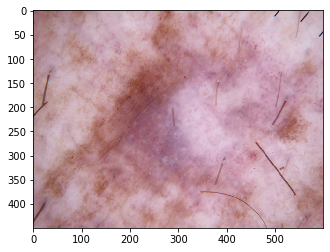

In [8]:
plt.imshow(cv2.cvtColor(X[100], cv2.COLOR_BGR2RGB))
y[100]

### Images preprocessing

I define and apply a preprocessingImage function that convert in gray scale each image and normalized them dividing each pixel by 255.

In [34]:
def preprocessImage(dataset):
    scaled_dataset = list()
    for img in dataset:
        img_resize = cv2.resize(img, (64,64))
        gray = cv2.cvtColor(img_resize,cv2.COLOR_BGR2GRAY)
        gray = gray.astype('float32') / 255.
        gray = np.expand_dims(gray,axis=-1)
        scaled_dataset.append(gray)
    scaled_dataset = np.array(scaled_dataset)
    
    return scaled_dataset

In [35]:
X = preprocessImage(X)

### Oversampling

Now, as I explained previously, I use smote algorithm to obtain a perfectly balanced dataset.

In [37]:
sm = SMOTE(random_state=42)
X, y = sm.fit_resample(X.reshape(np.shape(X)[0],-1), y)

And I fix dimensions after smote to make the dataset ready for the CNN. 

In [38]:
print(np.shape(X))
X = X.reshape((np.shape(X)[0],64,64))
X = np.expand_dims(X, axis=-1)
print(np.shape(X))

(11900, 4096)
(11900, 64, 64, 1)


Let's look at an example of synthetic image:

'mel'

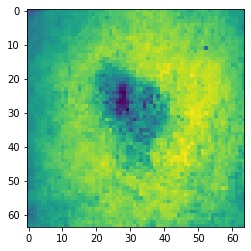

In [39]:
plt.imshow(X[10016,:,:,0])
y[10016]

### Training and Test sets

Finally I create training and test datasets.

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

And I One-Hot encode the target feature.

In [60]:
le = LabelEncoder()
le.fit(y)
y_train = le.transform(y_train)
y_train = np_utils.to_categorical(y_train)
y_encoded = le.transform(y)
y_encoded = np_utils.to_categorical(y_encoded)

## Results

After the hypeparameter tuning I obtain the following Convolutional Neural Network:

In [24]:
def tuned_cnn():
    model = Sequential()
    model.add(Conv2D(32, (5,5), activation='relu', padding='same', input_shape=(64,64,1)))
    model.add(AveragePooling2D(2,2))
    model.add(Conv2D(128, (5,5), activation='relu', padding='same'))
    model.add(AveragePooling2D(2,2))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(7, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
    return model

In [61]:
model = tuned_cnn()
model.fit(X_train, y_train, epochs=70, batch_size=36)

Epoch 1/70
265/265 [==============================] - 38s 144ms/step - loss: 1.7316 - accuracy: 0.2822
Epoch 2/70
265/265 [==============================] - 39s 146ms/step - loss: 1.5120 - accuracy: 0.3984
Epoch 3/70
265/265 [==============================] - 39s 147ms/step - loss: 1.3353 - accuracy: 0.4893
Epoch 4/70
265/265 [==============================] - 39s 149ms/step - loss: 1.1241 - accuracy: 0.5792
Epoch 5/70
265/265 [==============================] - 39s 148ms/step - loss: 0.9253 - accuracy: 0.6619
Epoch 6/70
265/265 [==============================] - 37s 141ms/step - loss: 0.7593 - accuracy: 0.7194
Epoch 7/70
265/265 [==============================] - 38s 143ms/step - loss: 0.6263 - accuracy: 0.7720
Epoch 8/70
265/265 [==============================] - 37s 141ms/step - loss: 0.5088 - accuracy: 0.8145
Epoch 9/70
265/265 [==============================] - 40s 150ms/step - loss: 0.4375 - accuracy: 0.8452
Epoch 10/70
265/265 [==============================] - 38s 145ms/step - l

In [62]:
y_pred = le_train.inverse_transform(np.argmax(model.predict(X_test), axis=1))

In [63]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       akiec       0.91      0.98      0.95       347
         bcc       0.91      0.93      0.92       320
         bkl       0.72      0.72      0.72       330
          df       0.98      1.00      0.99       388
         mel       0.71      0.72      0.71       325
          nv       0.75      0.63      0.68       336
        vasc       0.97      1.00      0.98       334

    accuracy                           0.86      2380
   macro avg       0.85      0.85      0.85      2380
weighted avg       0.85      0.86      0.85      2380



## K-fold cross validation

Now we compute the medium accuracy of the model through four KFold splits for having a measure of the model its solidity and if it's overfitted:

In [47]:
kf = KFold(n_splits=4, shuffle=True)

In [48]:
iteration = 0
kfold_accuracies = []
for train_index, test_index in kf.split(X):
    iteration += 1
    print('Starting KFold', iteration)
    kfold_cnn = tuned_cnn()
    kfold_cnn.fit(X[train_index], y_encoded[train_index], epochs=70, batch_size=38)
    y_pred_kfold = le_train.inverse_transform(np.argmax(kfold_cnn.predict(X[test_index]),axis=1))
    kfold_accuracies.append(accuracy_score(y_pred_kfold, np.array(y)[test_index]))

Starting KFold 1
Epoch 1/70
235/235 [==============================] - 34s 145ms/step - loss: 1.7490 - accuracy: 0.2681
Epoch 2/70
235/235 [==============================] - 33s 142ms/step - loss: 1.5289 - accuracy: 0.3955
Epoch 3/70
235/235 [==============================] - 33s 141ms/step - loss: 1.3540 - accuracy: 0.4820
Epoch 4/70
235/235 [==============================] - 33s 139ms/step - loss: 1.1212 - accuracy: 0.5860
Epoch 5/70
235/235 [==============================] - 33s 138ms/step - loss: 0.9218 - accuracy: 0.6621
Epoch 6/70
235/235 [==============================] - 32s 138ms/step - loss: 0.7620 - accuracy: 0.7220
Epoch 7/70
235/235 [==============================] - 33s 139ms/step - loss: 0.6235 - accuracy: 0.7727
Epoch 8/70
235/235 [==============================] - 33s 139ms/step - loss: 0.5142 - accuracy: 0.8174
Epoch 9/70
235/235 [==============================] - 33s 140ms/step - loss: 0.4097 - accuracy: 0.8519
Epoch 10/70
235/235 [==============================] - 3

235/235 [==============================] - 33s 139ms/step - loss: 0.5794 - accuracy: 0.7923
Epoch 9/70
235/235 [==============================] - 32s 137ms/step - loss: 0.4731 - accuracy: 0.8267
Epoch 10/70
235/235 [==============================] - 32s 137ms/step - loss: 0.3833 - accuracy: 0.8614
Epoch 11/70
235/235 [==============================] - 33s 139ms/step - loss: 0.3180 - accuracy: 0.8914
Epoch 12/70
235/235 [==============================] - 32s 138ms/step - loss: 0.2780 - accuracy: 0.9017
Epoch 13/70
235/235 [==============================] - 32s 138ms/step - loss: 0.2192 - accuracy: 0.9277
Epoch 14/70
235/235 [==============================] - 33s 141ms/step - loss: 0.1815 - accuracy: 0.9390
Epoch 15/70
235/235 [==============================] - 33s 142ms/step - loss: 0.1526 - accuracy: 0.9496
Epoch 16/70
235/235 [==============================] - 32s 137ms/step - loss: 0.1315 - accuracy: 0.9569
Epoch 17/70
235/235 [==============================] - 33s 139ms/step - loss:

235/235 [==============================] - 33s 140ms/step - loss: 0.0659 - accuracy: 0.9801
Epoch 23/70
235/235 [==============================] - 33s 139ms/step - loss: 0.0878 - accuracy: 0.9738
Epoch 24/70
235/235 [==============================] - 33s 139ms/step - loss: 0.0716 - accuracy: 0.9771
Epoch 25/70
235/235 [==============================] - 33s 139ms/step - loss: 0.0621 - accuracy: 0.9817
Epoch 26/70
235/235 [==============================] - 32s 138ms/step - loss: 0.0536 - accuracy: 0.9831
Epoch 27/70
235/235 [==============================] - 33s 142ms/step - loss: 0.0375 - accuracy: 0.9898
Epoch 28/70
235/235 [==============================] - 32s 138ms/step - loss: 0.0454 - accuracy: 0.9860
Epoch 29/70
235/235 [==============================] - 32s 138ms/step - loss: 0.0319 - accuracy: 0.9913
Epoch 30/70
235/235 [==============================] - 33s 140ms/step - loss: 0.0549 - accuracy: 0.9830
Epoch 31/70
235/235 [==============================] - 33s 139ms/step - loss

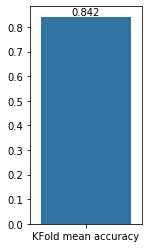

In [75]:
splot = sb.barplot(["KFold mean accuracy"], [np.mean(kfold_accuracies)])
plt.rcParams['figure.figsize'] = (4,9)
for p in splot.patches:
    splot.annotate(format(p.get_height(),'.3f'), (p.get_x() + p.get_width()/2., p.get_height()), 
                   ha='center', va='center', xytext=(0,5), textcoords='offset points')

## Features importance

I conclude this analysis computing importance of each pixel in the classification task using impurity-based method.

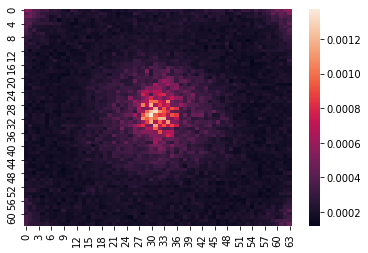

In [15]:
tree_model = ExtraTreesClassifier(n_estimators=250, random_state=0)
X_train_flat = X_train.reshape(np.shape(X_train)[0], np.shape(X_train)[1]*np.shape(X_train)[2])
tree_model.fit(X_train_flat, y_train)
features_importance = tree_model.feature_importances_
sb.heatmap(features_importance.reshape(np.shape(X_train)[1], np.shape(X_train)[2]))

Finally I save pixels' importance, that will be important for the second approach.

In [18]:
hkl.dump(features_importance, 'importances.hkl')